<a href="https://colab.research.google.com/github/yonigresearch-wq/ML-workflows/blob/main/Comparison_of_income_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code builds a NN for classification of income into 1 of 2 income categories, i.e., above or below some threshold. I also compare the performance of 2 classic ML classifiers (SVM and RSF).

In [ ]:
# Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# data - income data from 1994 US census
!pip install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
census_income = fetch_ucirepo(id=20)

# data (as pandas dataframes)
X = census_income.data.features
y = census_income.data.targets

print(census_income.variables)

# dimensions of data
X.shape

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

(48842, 14)

Our data has 48,842 observations and 14 variables. Our data also includes missing data. We can use an imputation method for this.

In [ ]:
# Create 2 binary categories for y

np.unique(y)

y[y == '>50K.'] = '>50K'
y[y == '<=50K.'] = '<=50K'

np.unique(y)


/tmp/ipython-input-1764449765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == '>50K.'] = '>50K'
/tmp/ipython-input-1764449765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == '>50K.'] = '>50K'
/tmp/ipython-input-1764449765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == '<=50K.'] = '<=50K'
/t

array(['<=50K', '>50K'], dtype=object)

In [ ]:
# Explore missing information

print(X.isna().sum())

for col in range(X.shape[1]):

  if X.iloc[:, col].isna().sum() > 0:
    print(X.iloc[:, col].unique())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yu

We see that all the missing values are in categorical columns. Simply imputing the most frequent category can be problematic. In addition, the missing data may have information in itself, so rather than  imputing it, let's create variables that encode whether this information is missing.

In [ ]:
from sklearn.impute import SimpleImputer

# Unite all missing data to a single category for consistency within variables

missing_ind = X.isna().sum()>0
missing_vars = missing_ind[missing_ind == True].index

for var in missing_vars:
  X[var] = X[var].fillna("?")

# Varify that we now have no missing data

print(X.isna().sum())


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64


/tmp/ipython-input-2476586589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[var] = X[var].fillna("?")


In [ ]:
# Now that we have consistent categries of missingness, we can add missing indicator variables

for var in missing_vars:
  X[var+'_miss'] = (X[var] != "?").astype(int)


In [ ]:
# Make sure the indicator variables have been added

X.shape

(48842, 17)

Now that we've handeld the missing data imputation, we can split to train and test sets and then transform our data into tensors, in order to run it through our NN.

In [ ]:
# Convert categorical varibles to integers

from sklearn.preprocessing import OrdinalEncoder

cat_cols = X.select_dtypes(include=['object', 'category']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
y = encoder.fit_transform(y)

# Train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Convert data into tensors

X_tr, X_te = torch.FloatTensor(X_train.values), torch.FloatTensor(X_test.values)
y_tr, y_te = torch.tensor(y_train, dtype=torch.long).squeeze(), torch.tensor(y_test, dtype=torch.long).squeeze()



In [ ]:
# Let's look at the dimensions of our tensors

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

(torch.Size([39073, 17]),
 torch.Size([9769, 17]),
 torch.Size([39073]),
 torch.Size([9769]))

Now that we've taken care of our data preprocessing, we can construct our nueral network .

In [ ]:
# Construction of model class

class IncomeClassifier(nn.Module):
  def __init__(self, in_features=17, h1=128, h2=32, h3=15, out_features=2):
    # Input size - 17 variables
    # 3 hidden layers of size 128, 64 and 32
    # output size - 2 (binary classifier)

    super().__init__() # use super since we are using a parent class
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.out = nn.Linear(h3, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    out = self.out(x)

    return out



In [ ]:
# Construction of model class

class IncomeClassifier(nn.Module):
  def __init__(self, in_features=17, h1=128, h2=64, h3=32, out_features=2):
    super().__init__() # use super since we are using a parent class

    def make_block(dim_in, dim_out, dropout=0.2):
      return nn.Sequential(
        nn.Linear(dim_in, dim_out), # linear layer
        nn.BatchNorm1d(dim_out), # normalize data
        nn.ReLU(), # relu activation function
        nn.Dropout(dropout) # dropout
      )

    self.block1 = make_block(in_features, h1)
    self.block2 = make_block(h1, h2)
    self.block3 = make_block(h2, h3)
    self.out = nn.Linear(h3, out_features)
    # No activation function or dropout for output layer

  def forward(self, x):
    x = self.block1(x, )
    x = self.block2(x)
    x = self.block3(x)
    out = self.out(x)

    return out

In [ ]:
model = IncomeClassifier()
model

IncomeClassifier(
  (block1): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (out): Linear(in_features=32, out_features=2, bias=True)
)

Now that we've constructed our model, we can train and validate it on our data.

In [ ]:
# Define loss, optimizer and step size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop

epochs = 2000
train_losses = []
test_losses = []

for epoch in range(epochs):

  # run data through forward and obtain prediction
  y_tr_pred = model(X_tr)
  y_te_pred = model(X_te)

  # calculate loss
  loss_tr = criterion(y_tr_pred, y_tr)
  loss_te = criterion(y_te_pred, y_te)

  # track losses
  train_losses.append(loss_tr.item())
  test_losses.append(loss_te.item())

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}, Training Loss = {loss_tr}, Test Loss = {loss_te}')

  # apply back-propogation and update parameters
  optimizer.zero_grad() # zero out current gradients
  loss_tr.backward() # calculate gradients
  optimizer.step() # take step in direction of steepest descent


Epoch: 0, Training Loss = 0.6731746792793274, Test Loss = 0.673822820186615
Epoch: 10, Training Loss = 0.5135320425033569, Test Loss = 0.5162911415100098
Epoch: 20, Training Loss = 0.4980646073818207, Test Loss = 0.5009244084358215
Epoch: 30, Training Loss = 0.49053505063056946, Test Loss = 0.49395209550857544
Epoch: 40, Training Loss = 0.4859205484390259, Test Loss = 0.49152523279190063
Epoch: 50, Training Loss = 0.4845019280910492, Test Loss = 0.4901195168495178
Epoch: 60, Training Loss = 0.4829648435115814, Test Loss = 0.48900943994522095
Epoch: 70, Training Loss = 0.4815417230129242, Test Loss = 0.4890919625759125
Epoch: 80, Training Loss = 0.4799903333187103, Test Loss = 0.4889400601387024
Epoch: 90, Training Loss = 0.47951894998550415, Test Loss = 0.48744943737983704
Epoch: 100, Training Loss = 0.47890928387641907, Test Loss = 0.48589637875556946
Epoch: 110, Training Loss = 0.4795762002468109, Test Loss = 0.4870772063732147
Epoch: 120, Training Loss = 0.4796375334262848, Test Los

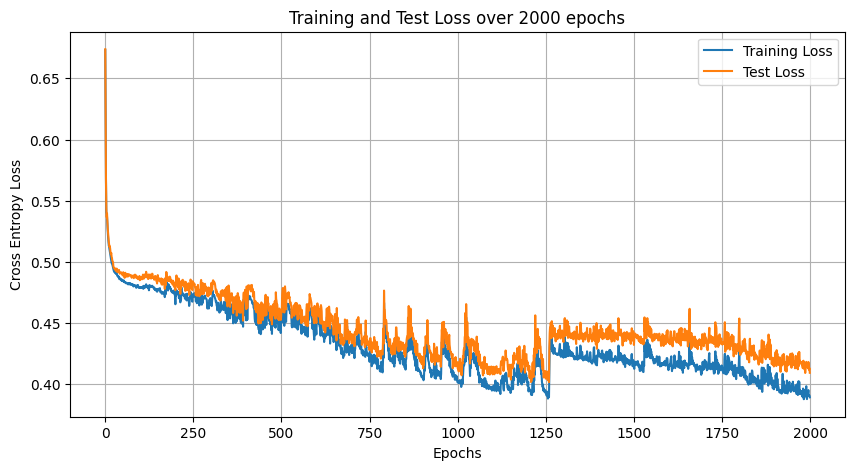

In [ ]:
# Plot of loss over epochs
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label='Training Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')
ax.legend()
ax.grid()
ax.title.set_text('Training and Test Loss over 2000 epochs')

In [ ]:
# let's check what the percentage of incorrect predictions is

y_te_pred = torch.argmax(y_te_pred, dim=1)
print(f'\nIncorrect classifications = {sum(np.abs(y_te_pred - y_te))} / {len(y_te)}')


Incorrect classifications = 1904 / 9769


/tmp/ipython-input-1982979168.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'\nIncorrect classifications = {sum(np.abs(y_te_pred - y_te))} / {len(y_te)}')


Let's compare this to other ML classifiction methods

In [ ]:
# Classification using SVM

from sklearn.svm import SVC

# Flatten target vectors
y_train = y_train.ravel()
y_test  = y_test.ravel()

# Fit model on training data and predict test data
svc_mod = SVC()
svc_mod.fit(X_train, y_train)
y_pred = svc_mod.predict(X_test)
incorrect = np.sum(y_pred != y_test)
print(f"\nIncorrect classifications = {incorrect} / {len(y_test)}")



Incorrect classifications = 1976 / 9769


In [ ]:
# Classification using trees
# We can tune parameters using k-fold CV

from sklearn.ensemble import RandomForestClassifier

# Flatten target vectors
y_train = y_train.ravel()
y_test  = y_test.ravel()

rsf_mod = RandomForestClassifier(max_depth=20, n_estimators=100, oob_score=True)
rsf_mod.fit(X_train, y_train)
y_pred = rsf_mod.predict(X_test)

incorrect = np.sum(y_pred != y_test)
print(f"\nIncorrect classifications = {incorrect} / {len(y_test)}")



Incorrect classifications = 1341 / 9769


Before any tuning, we can see that out random forest classifier completley outperforms both SVM and our 3 layer NN.